In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import torch

import pandas as pd


df = pd.read_excel('/content/unimputed_data.xlsx')

# Define your feature groups
num_cols = ['Age', 'IncomeRatio', 'Weight', 'BMI',
            'Triglyceride (mg/dL)', 'LDL-Cholesterol (mg/dL)', 'HDL-Cholesterol (mg/dL)']

cat_cols = ['Gender', 'Race', 'EducationLevel', 'Diabetes',
            'SleepProblem', 'Smokes', 'AlcoholConsumption']

target = 'Depression_Label'


# Drop rows with missing values in selected columns
df['Depression_Label'] = df['Depression_Label'].apply(lambda x: 1 if x == 2 else x)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 1 else 0)

In [ ]:
df

,Unnamed: 0,Age,Gender,Race,MaritalStatus,IncomeRatio,EducationLevel,Depression_Label,Weight,BMI,Triglyceride (mg/dL),LDL-Cholesterol (mg/dL),HDL-Cholesterol (mg/dL),Diabetes,SleepProblem,Smokes,AlcoholConsumption
0,44700,76,1,3,1,3.61,5,0,83.3,26.6,132,164,43,0,1,1,0
1,44705,68,0,4,2,5.00,5,0,73.0,28.1,102,105,40,1,0,0,0
2,44707,58,1,2,2,1.60,3,0,86.0,30.5,90,102,52,1,1,0,0
3,44726,49,0,3,2,2.74,4,0,64.2,24.0,63,108,60,0,0,0,0
4,44734,55,0,4,3,0.11,3,0,107.2,39.6,111,109,52,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1967,54854,54,0,6,1,5.00,4,0,64.1,27.8,119,99,52,1,0,0,0
1968,54856,36,0,3,1,0.33,4,0,84.6,28.4,138,147,71,0,0,1,1
1969,54859,80,0,4,2,2.73,3,0,84.1,34.2,125,90,64,0,0,0,0
1970,54880,62,0,2,1,5.00,4,0,73.0,28.7,101,137,66,0,1,1,0


In [ ]:
df.AlcoholConsumption.value_counts()

,count
AlcoholConsumption,
0,1674
1,298


In [ ]:
cat_cols = ['Race', 'EducationLevel']

bin_cols = ['Gender', 'Diabetes','SleepProblem', 'Smokes', 'AlcoholConsumption']

In [ ]:
y = df[target]

# Combine preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
    ('bin', OrdinalEncoder(), bin_cols)
])

In [ ]:
X = preprocessor.fit_transform(df[num_cols + cat_cols + bin_cols])

In [ ]:
preprocessor.get_feature_names_out()

array(['num__Age', 'num__IncomeRatio', 'num__Weight', 'num__BMI',
       'num__Triglyceride (mg/dL)', 'num__LDL-Cholesterol (mg/dL)',
       'num__HDL-Cholesterol (mg/dL)', 'cat__Race_1', 'cat__Race_2',
       'cat__Race_3', 'cat__Race_4', 'cat__Race_6', 'cat__Race_7',
       'cat__EducationLevel_1', 'cat__EducationLevel_2',
       'cat__EducationLevel_3', 'cat__EducationLevel_4',
       'cat__EducationLevel_5', 'bin__Gender', 'bin__Diabetes',
       'bin__SleepProblem', 'bin__Smokes', 'bin__AlcoholConsumption'],
      dtype=object)

In [ ]:
X

array([[ 1.5278674 ,  0.63216094, -0.10783403, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.06527002,  1.49520125, -0.53098694, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48702331, -0.61583261,  0.00308954, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.75916608,  0.08577571, -0.07496779, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.718322  ,  1.49520125, -0.53098694, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.77614667,  0.69425017, -0.2639487 , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:


# Convert to PyTorch tensors
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)

print("Feature shape:", X_t.shape)
print("Label shape:", y_t.shape)


Feature shape: torch.Size([1972, 23])
Label shape: torch.Size([1972])


In [ ]:
df.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Race', 'MaritalStatus', 'IncomeRatio',
       'EducationLevel', 'Depression_Label', 'Weight', 'BMI',
       'Triglyceride (mg/dL)', 'LDL-Cholesterol (mg/dL)',
       'HDL-Cholesterol (mg/dL)', 'Diabetes', 'SleepProblem', 'Smokes',
       'AlcoholConsumption'],
      dtype='object')

In [ ]:
df['Depression_Label'].value_counts()

,count
Depression_Label,
0,1762
1,210


In [ ]:
from imblearn.over_sampling import SMOTE

# Convert tensors to numpy for SMOTE
X_np = X_t.numpy()
y_np = y_t.numpy()

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_np, y_np)

# Convert back to torch tensors
X_t = torch.tensor(X_resampled, dtype=torch.float32)
y_t = torch.tensor(y_resampled, dtype=torch.long)

print("After SMOTE → X:", X_t.shape, "| y:", y_t.shape)


After SMOTE → X: torch.Size([3524, 23]) | y: torch.Size([3524])


In [ ]:
len(y_t[y_t == 0]), len(y_t[y_t == 1])

(1762, 1762)

Starting training…
Epoch 1/100  Train Loss: 0.6739 | Train Acc: 0.5906  Val Loss: 0.6513 | Val Acc: 0.6326
Epoch 2/100  Train Loss: 0.6040 | Train Acc: 0.6829  Val Loss: 0.5690 | Val Acc: 0.7135
Epoch 3/100  Train Loss: 0.5411 | Train Acc: 0.7361  Val Loss: 0.5560 | Val Acc: 0.7404
Epoch 4/100  Train Loss: 0.5134 | Train Acc: 0.7492  Val Loss: 0.5054 | Val Acc: 0.7518
Epoch 5/100  Train Loss: 0.4964 | Train Acc: 0.7669  Val Loss: 0.5033 | Val Acc: 0.7589
Epoch 6/100  Train Loss: 0.4831 | Train Acc: 0.7755  Val Loss: 0.4879 | Val Acc: 0.7631
Epoch 7/100  Train Loss: 0.4754 | Train Acc: 0.7804  Val Loss: 0.4756 | Val Acc: 0.7773
Epoch 8/100  Train Loss: 0.4492 | Train Acc: 0.7985  Val Loss: 0.4611 | Val Acc: 0.7787
Epoch 9/100  Train Loss: 0.4404 | Train Acc: 0.8035  Val Loss: 0.4499 | Val Acc: 0.7872
Epoch 10/100  Train Loss: 0.4380 | Train Acc: 0.8024  Val Loss: 0.4306 | Val Acc: 0.7986
Epoch 11/100  Train Loss: 0.4110 | Train Acc: 0.8162  Val Loss: 0.4239 | Val Acc: 0.8014
Epoch 12/10

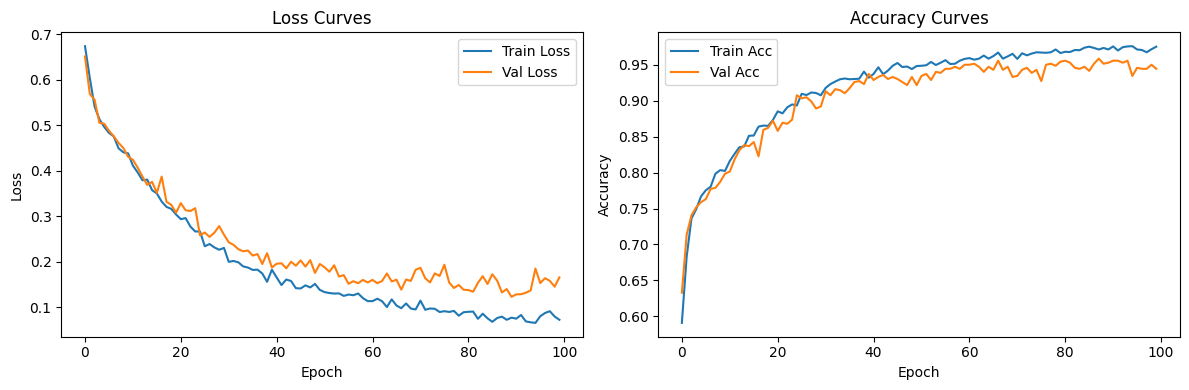

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ─── 1. Model ────────────────────────────────────────────────────────────────
class AttWideDeep(nn.Module):
    def __init__(self, input_dim):
        super(AttWideDeep, self).__init__()
        self.fc1   = nn.Linear(input_dim, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.2)
        self.fc3   = nn.Linear(64, 64)
        self.drop3 = nn.Dropout(0.2)
        self.out   = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        x = torch.sigmoid(self.out(x))   # Output in [0,1]
        return x

# ─── 2. Training / Validation Loops ─────────────────────────────────────────
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in dataloader:
        xb = xb.to(device)
        yb = yb.unsqueeze(1).float().to(device)   # [batch,1]

        optimizer.zero_grad()
        outputs = model(xb)                        # [batch,1]
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

        # binary predictions: threshold at 0.5
        preds  = (outputs >= 0.5).long()           # [batch,1]
        labels = yb.long()                         # [batch,1]
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.unsqueeze(1).float().to(device)

            outputs = model(xb)
            loss = criterion(outputs, yb)
            running_loss += loss.item() * xb.size(0)

            preds  = (outputs >= 0.5).long()
            labels = yb.long()
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

# ─── 3. Setup & DataLoaders ─────────────────────────────────────────────────
device = torch.device('cuda')


# 1) make an index array
idx = np.arange(X_t.shape[0])           # numpy array [0,1,2,…,N-1]

# 2) split indices
train_idx_np, val_idx_np = train_test_split(
    idx,
    test_size=0.2,
    random_state=42
)

# 3) (if X_t/y_t are torch tensors) convert to LongTensor
train_idx = torch.from_numpy(train_idx_np).long()
val_idx   = torch.from_numpy(val_idx_np).long()

# 4) slice your data & labels
X_train = X_t[train_idx]
X_val   = X_t[val_idx]
y_train = y_t[train_idx]
y_val   = y_t[val_idx]



train_ds     = TensorDataset(X_train, y_train)
val_ds       = TensorDataset(X_val,   y_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# ─── 4. Model, Criterion, Optimizer ─────────────────────────────────────────
model     = AttWideDeep(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ─── 5. Training Loop ────────────────────────────────────────────────────────
num_epochs = 100
history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

print("Starting training…")
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = validate(model,   val_loader,   criterion, device=device)

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}  "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("Training complete.")

# ─── 6. Plot Metrics ────────────────────────────────────────────────────────
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Acc')
plt.plot(history['val_accuracy'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.unsqueeze(1).float().to(device)
        probs = model(xb)
        preds  = (probs >= 0.5).long()
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())

# Convert to arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("F1 Score:", f1_score(all_labels, all_preds))
print("Recall:", recall_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds))


F1 Score: 0.9433962264150944
Recall: 0.9938837920489296
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.95       378
         1.0       0.90      0.99      0.94       327

    accuracy                           0.94       705
   macro avg       0.95      0.95      0.94       705
weighted avg       0.95      0.94      0.94       705



Using validation data for SHAP analysis (real distribution, not SMOTE-balanced)
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (705, 23, 1)
Number of samples in explanation set: 705
Number of features: 23
Class '0' - SHAP values shape: (705, 23)


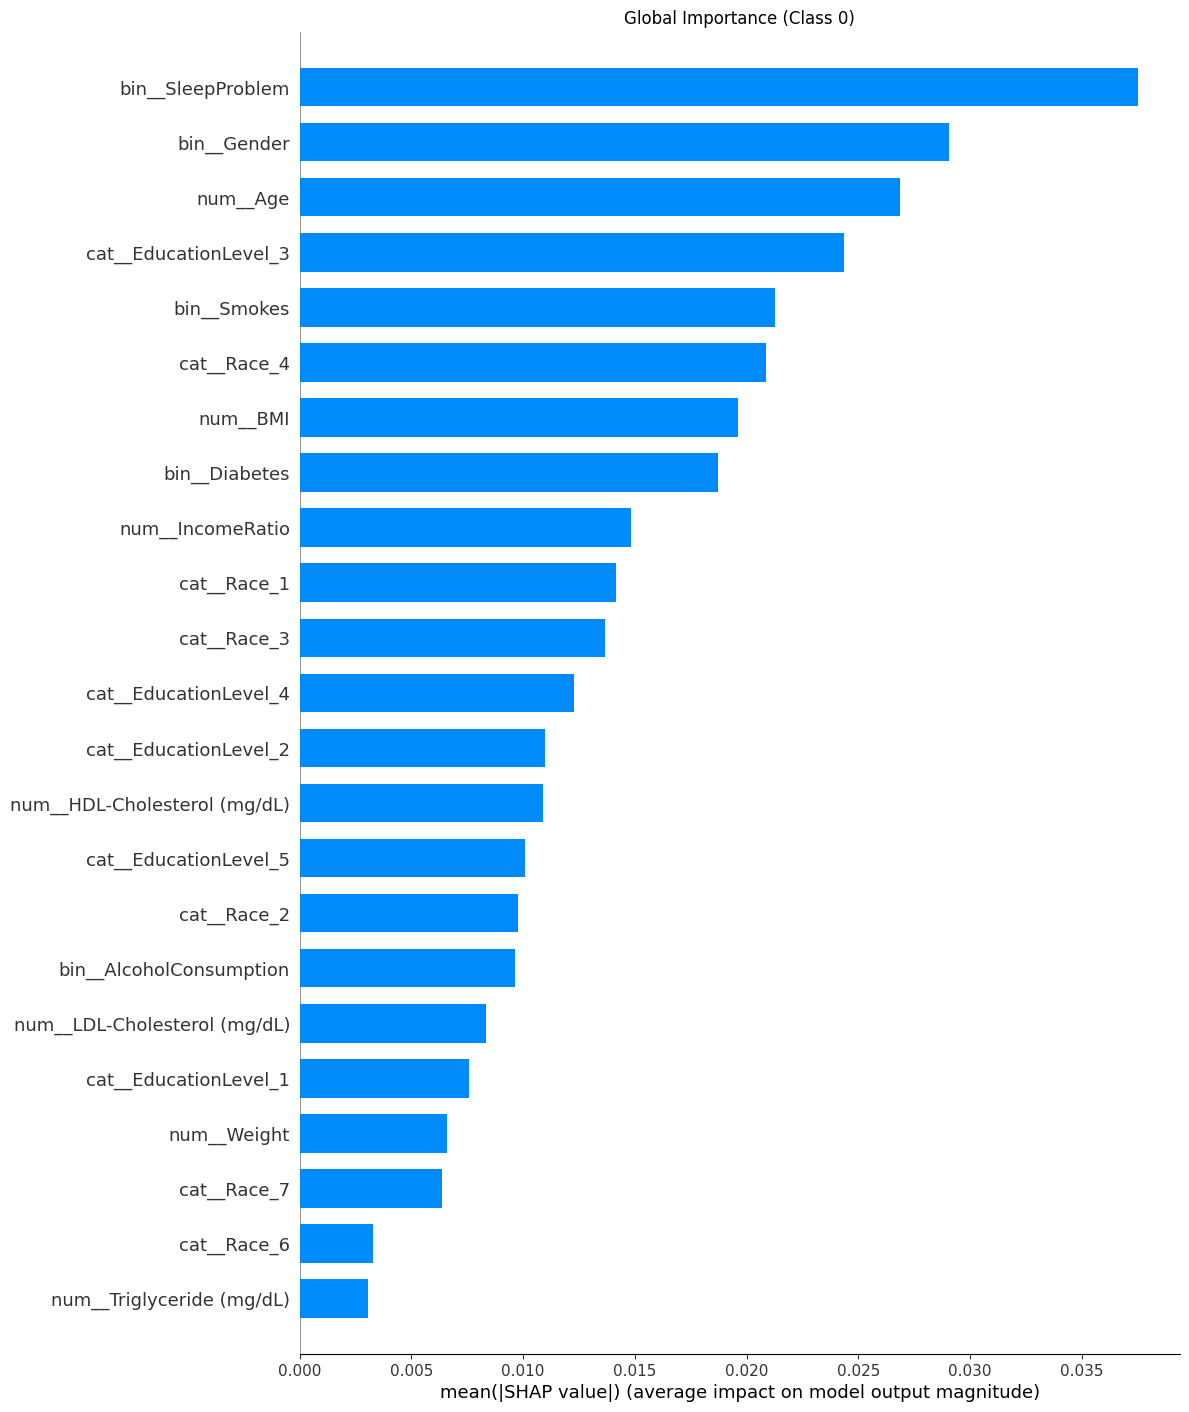

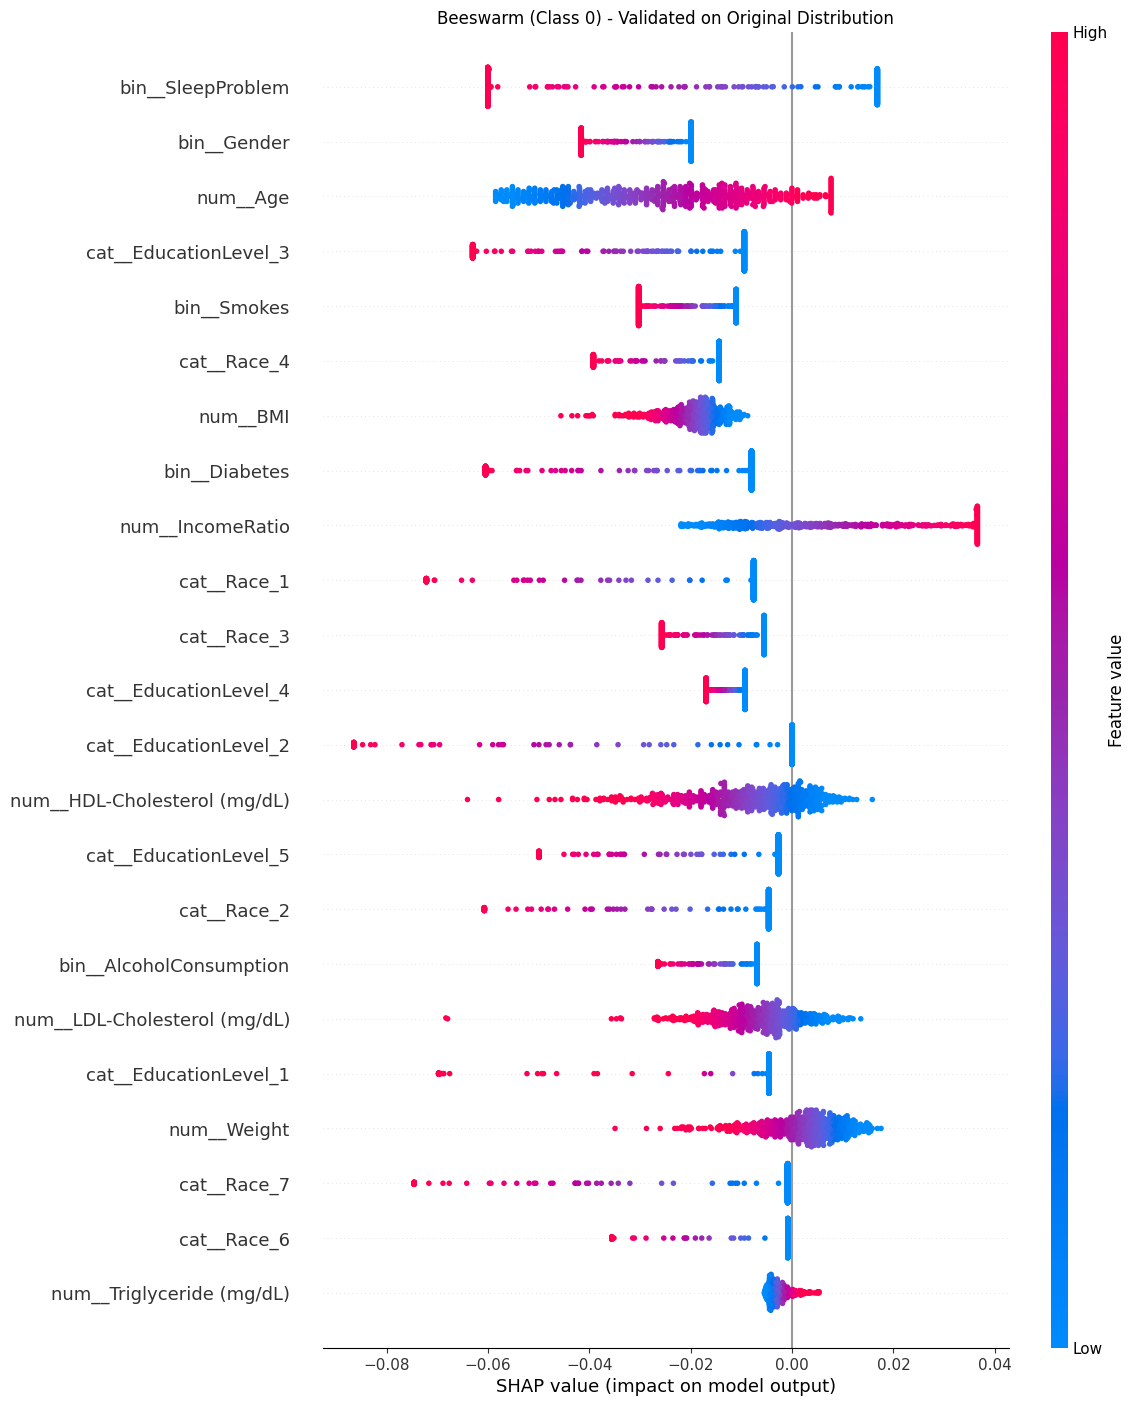

Class '1' - SHAP values shape: (705, 23)


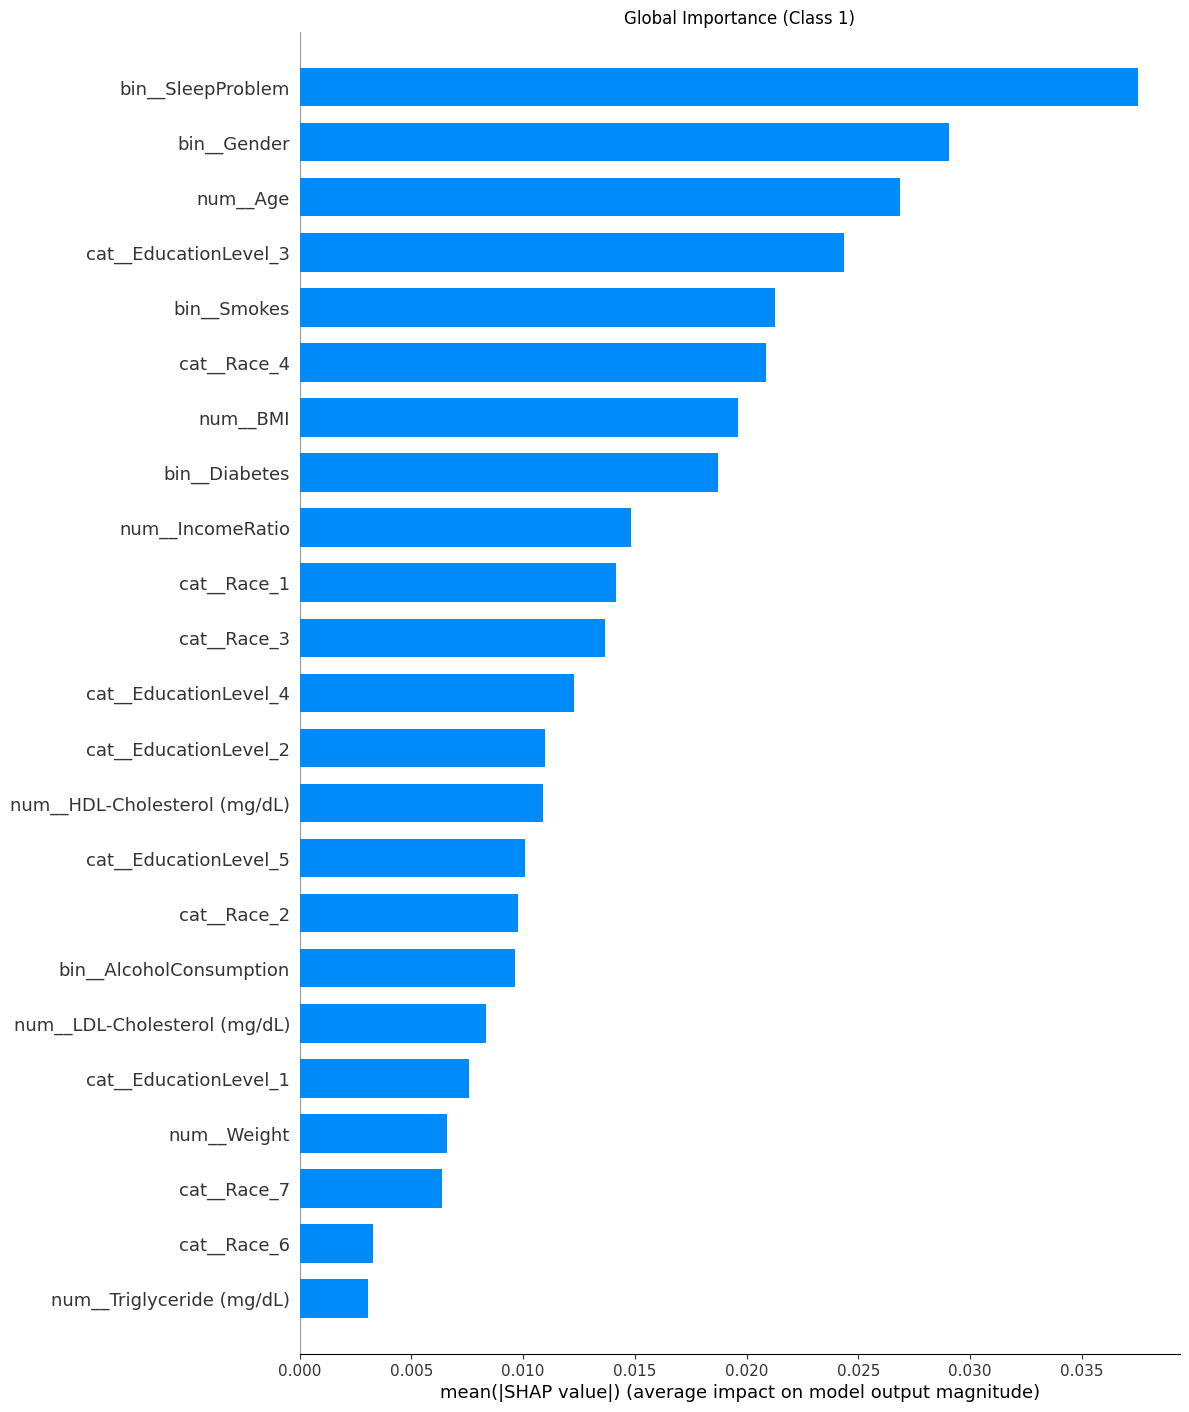

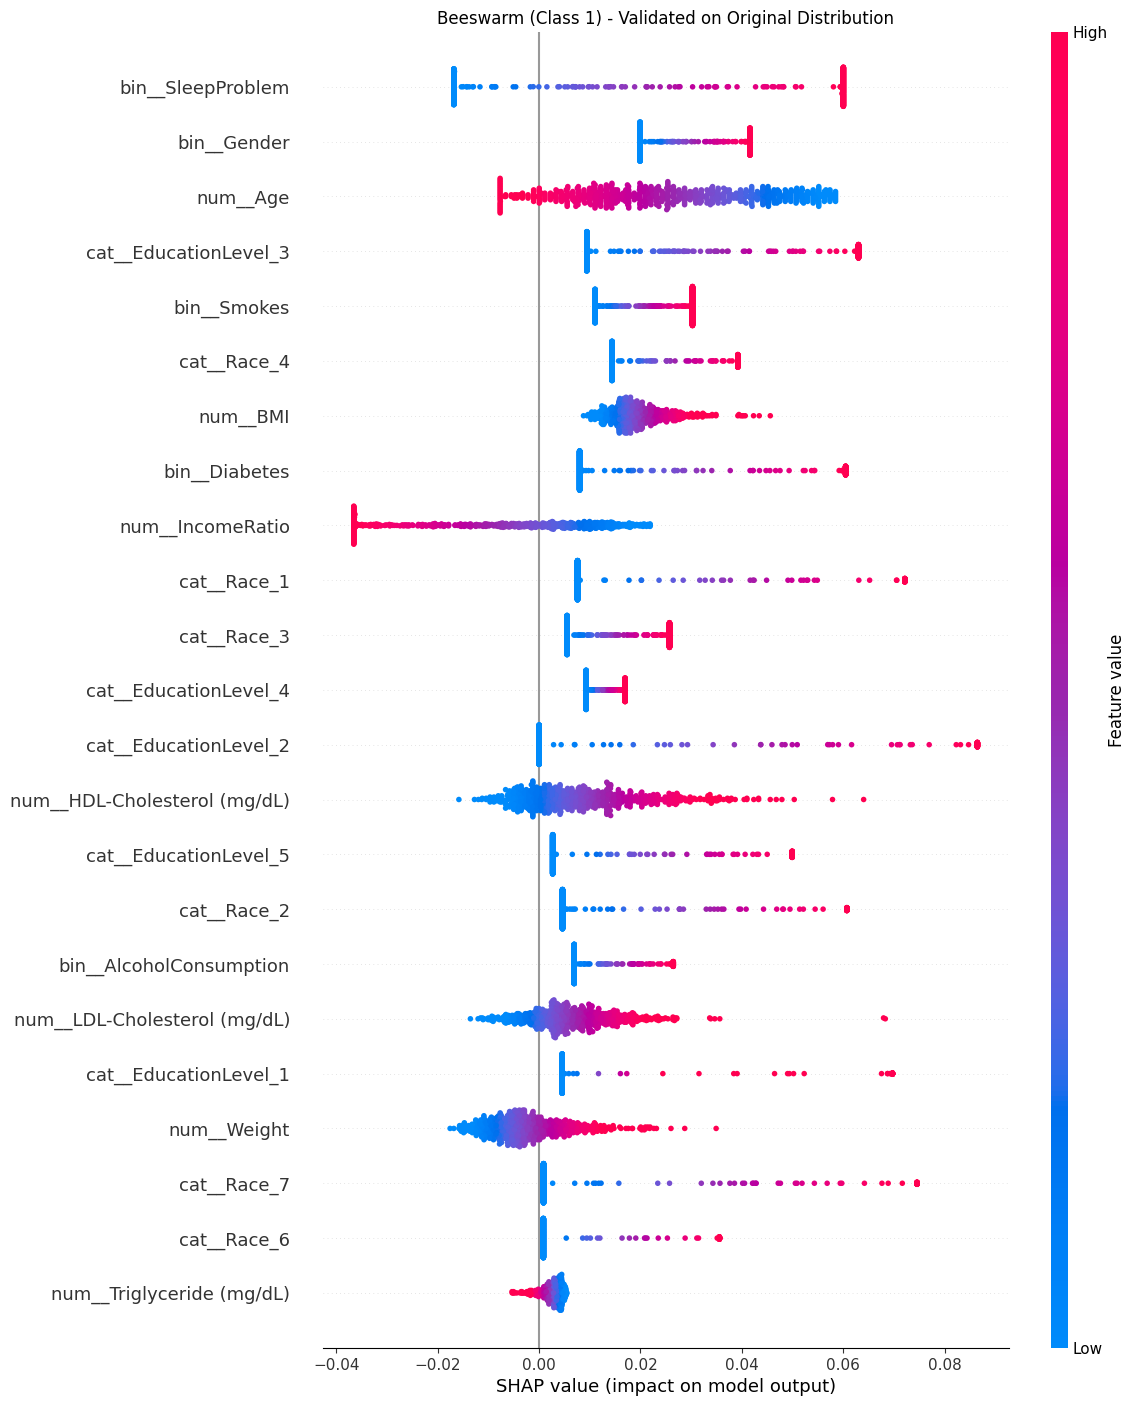

In [ ]:
# ─── 5. SHAP Explainer with SMOTE Considerations ─────────────────────────────
import numpy as np
import torch
import matplotlib.pyplot as plt
import shap

# Get feature names
feature_names = preprocessor.get_feature_names_out()
class_names = np.array([0,1])

# Important: Use original validation data (not SMOTE-synthetic) for SHAP analysis
# This ensures explanations reflect real data distributions
print("Using validation data for SHAP analysis (real distribution, not SMOTE-balanced)")

# Select background from validation set (real data, not synthetic)
background = X_t[val_idx][torch.randperm(len(val_idx))].to(device)
explainer = shap.DeepExplainer(model, background)

# Calculate SHAP values on validation data (real distribution)
X_explain = X_t[val_idx]  # Use validation set for explanation
shap_values = explainer.shap_values(X_explain, check_additivity=False)

print(f"SHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP values format: list of {len(shap_values)} arrays")
    print(f"First array shape: {shap_values[0].shape}")
    shap_values_per_class = shap_values
else:
    print(f"SHAP values shape: {np.array(shap_values).shape}")

    # For binary classification with sigmoid output
    if len(shap_values.shape) == 3 and shap_values.shape[2] == 1:
        # Reshape to remove singleton dimension: (samples, features, 1) -> (samples, features)
        shap_class_1 = shap_values[:, :, 0]
        # For class 0, negate the values (factors that decrease class 1 probability increase class 0)
        shap_class_0 = -shap_class_1
        shap_values_per_class = [shap_class_0, shap_class_1]  # Order by class indices (0, 1)
    elif len(shap_values.shape) == 3:
        # Regular multi-class case
        shap_values_per_class = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
    else:
        # If we have a 2D array (samples, features), it's for the positive class
        shap_values_per_class = [shap_values]  # Single class case

# Verify shapes
print(f"Number of samples in explanation set: {X_explain.shape[0]}")
print(f"Number of features: {len(feature_names)}")
X_explain_np = X_explain.cpu().numpy() if X_explain.is_cuda else X_explain.numpy()

# ─── 6. Global Importance & Beeswarm ─────────────────────────────────────────
# Plot SHAP visualizations for each class
for ci, cname in enumerate(class_names):
    if ci >= len(shap_values_per_class):
        print(f"Skipping class {cname} - SHAP values not available")
        continue

    vals = shap_values_per_class[ci]
    print(f"Class '{cname}' - SHAP values shape: {vals.shape}")

    # Ensure shapes match before plotting
    if vals.shape[0] == X_explain_np.shape[0] and vals.shape[1] == X_explain_np.shape[1]:
        # Plot the bar chart (global importance)
        shap.summary_plot(vals, X_explain_np,
                          feature_names=feature_names,
                          plot_type="bar",
                          max_display=len(feature_names),
                          plot_size=(12, 14),
                          show=False)
        plt.title(f"Global Importance (Class {cname})")
        plt.show()

        # Plot the beeswarm (individual feature impacts)
        shap.summary_plot(vals, X_explain_np,
                          feature_names=feature_names,
                          max_display=len(feature_names),
                          plot_size=(12, 14),
                          show=False)
        plt.title(f"Beeswarm (Class {cname}) - Validated on Original Distribution")
        plt.show()
    else:
        print(f"Warning: Shape mismatch for class {cname}. SHAP: {vals.shape}, X: {X_explain_np.shape}")
        if vals.shape[0] != X_explain_np.shape[0]:
            print("  → Number of samples doesn't match")
        if vals.shape[1] != X_explain_np.shape[1]:
            print("  → Number of features doesn't match")


In [ ]:
def compute_shap_interactions_paper_method(model, X_sample, feature_names, class_idx=0, num_background=100):
    """
    Compute pairwise feature interactions using proper Shapley interaction calculation.
    """
    # Detect device
    device = next(model.parameters()).device
    n_features = X_sample.shape[1]
    interaction_matrix = np.zeros((n_features, n_features))

    # Function for model prediction with device handling
    def predict_fn(x):
        with torch.no_grad():
            # Convert to tensor if numpy array
            if isinstance(x, np.ndarray):
                x_tensor = torch.tensor(x, dtype=torch.float32)
            else:
                x_tensor = x

            # Move to correct device
            x_tensor = x_tensor.to(device)

            # Get predictions and move back to CPU for numpy conversion
            preds = model(x_tensor).cpu().numpy()

            # Ensure output is 1D for KernelExplainer
            if len(preds.shape) > 1 and preds.shape[1] == 1:
                preds = preds.flatten()

            # For binary classification with sigmoid output:
            # - class_idx 0: probability of class 0
            # - class_idx 1: probability of class 1
            if class_idx == 0:
                return 1 - preds  # Return probability of class 0
            else:
                return preds      # Return probability of class 1

    # Test the prediction function
    test_pred = predict_fn(X_sample[:5])
    print(f"Sample predictions for class {class_idx}:")
    print(f"Shape: {test_pred.shape}, values: {test_pred}")

    # Convert data to numpy if needed
    X_sample_np = X_sample.cpu().numpy() if isinstance(X_sample, torch.Tensor) else X_sample

    # Choose random background samples
    bg_indices = np.random.choice(X_sample_np.shape[0], num_background, replace=False)
    background = X_sample_np[bg_indices]
    bg_mean = np.mean(background, axis=0)  # Mean feature values for background

    # For computational efficiency, use a smaller subset
    subset_size = min(50, X_sample_np.shape[0])
    X_subset = X_sample_np[:subset_size]

    print(f"Calculating interactions for class {class_idx} using {subset_size} samples...")

    # Calculate pairwise interactions using Shapley interaction formula
    for i in range(n_features):
        for j in range(i+1, n_features):
            interaction_values = []

            for idx in range(subset_size):
                sample = np.copy(X_subset[idx:idx+1])

                # Create 4 versions of the sample with different feature combinations

                # Version 1: Both features at original values
                sample_both = np.copy(sample)

                # Version 2: Feature i at original value, feature j at background
                sample_i = np.copy(sample)
                sample_i[0, j] = bg_mean[j]

                # Version 3: Feature j at original value, feature i at background
                sample_j = np.copy(sample)
                sample_j[0, i] = bg_mean[i]

                # Version 4: Both features at background value
                sample_none = np.copy(sample)
                sample_none[0, i] = bg_mean[i]
                sample_none[0, j] = bg_mean[j]

                # Predictions for all versions
                pred_both = predict_fn(sample_both)[0]
                pred_i = predict_fn(sample_i)[0]
                pred_j = predict_fn(sample_j)[0]
                pred_none = predict_fn(sample_none)[0]

                # Shapley interaction formula: f(i,j) - f(i) - f(j) + f()
                interaction = pred_both - pred_i - pred_j + pred_none
                interaction_values.append(interaction)

            # Average interaction value across samples
            avg_interaction = np.mean(interaction_values)

            # Store interaction value (symmetrically)
            interaction_matrix[i, j] = avg_interaction
            interaction_matrix[j, i] = avg_interaction

    # Return the interaction matrix
    return interaction_matrix


Using validation data for interaction analysis (real distribution, not SMOTE-synthetic)
Computing interactions for class: 0
Sample predictions for class 0:
Shape: (5,), values: [0.01054037 0.032157   0.00208682 0.9758712  0.9509616 ]
Calculating interactions for class 0 using 50 samples...


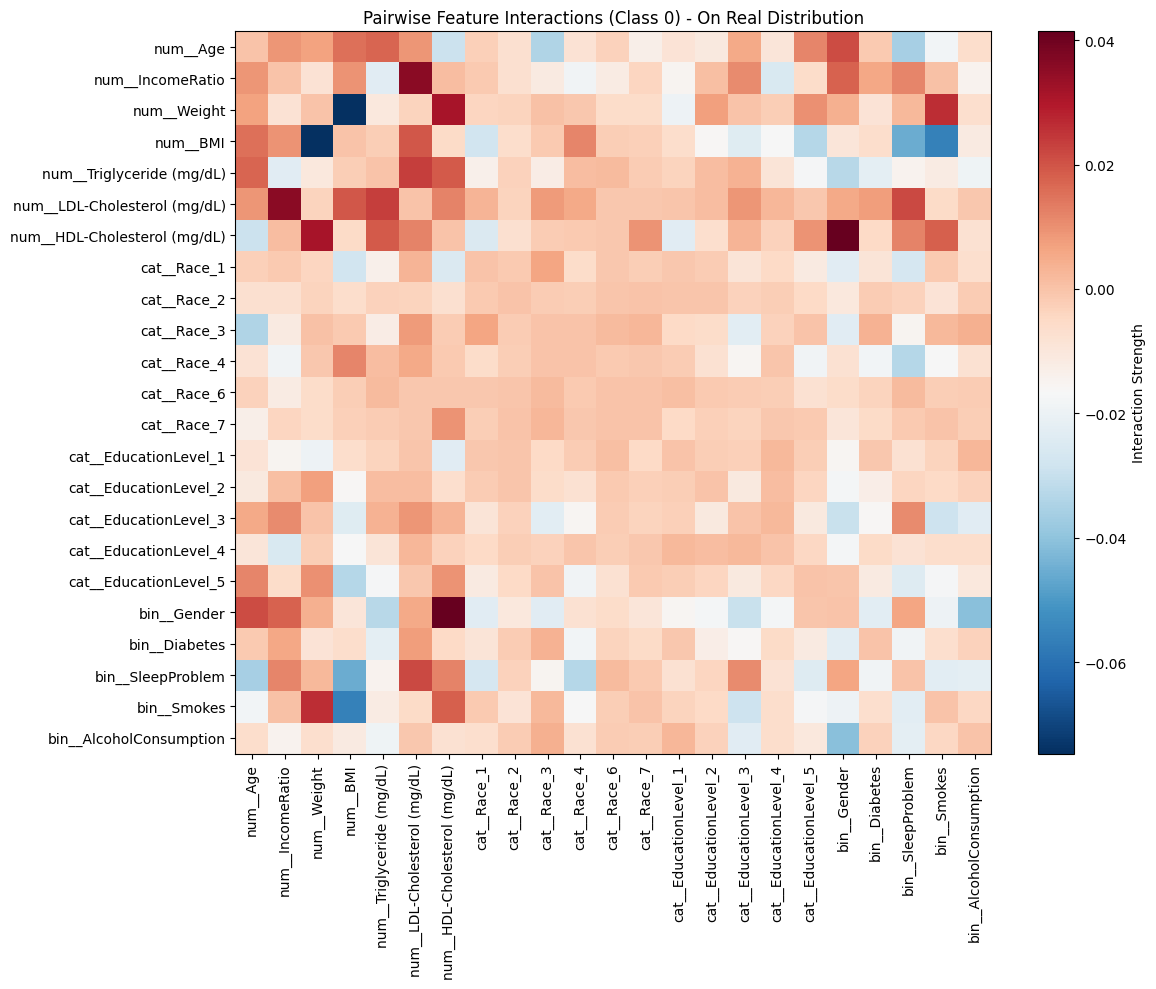

Top 20 Interactions for class 0:
num__Weight × num__BMI: -0.0746
num__BMI × bin__Smokes: -0.0557
num__BMI × bin__SleepProblem: -0.0455
num__HDL-Cholesterol (mg/dL) × bin__Gender: 0.0414
bin__Gender × bin__AlcoholConsumption: -0.0409
num__Age × bin__SleepProblem: -0.0357
num__IncomeRatio × num__LDL-Cholesterol (mg/dL): 0.0356
num__Age × cat__Race_3: -0.0340
num__BMI × cat__EducationLevel_5: -0.0332
cat__Race_4 × bin__SleepProblem: -0.0330
num__Triglyceride (mg/dL) × bin__Gender: -0.0325
num__Weight × num__HDL-Cholesterol (mg/dL): 0.0311
cat__EducationLevel_3 × bin__Gender: -0.0297
num__Age × num__HDL-Cholesterol (mg/dL): -0.0292
cat__EducationLevel_3 × bin__Smokes: -0.0285
num__BMI × cat__Race_1: -0.0276
cat__Race_1 × bin__SleepProblem: -0.0264
num__Weight × bin__Smokes: 0.0262
num__IncomeRatio × cat__EducationLevel_4: -0.0255
num__HDL-Cholesterol (mg/dL) × cat__Race_1: -0.0250
Computing interactions for class: 1
Sample predictions for class 1:
Shape: (5,), values: [0.98945963 0.967843 

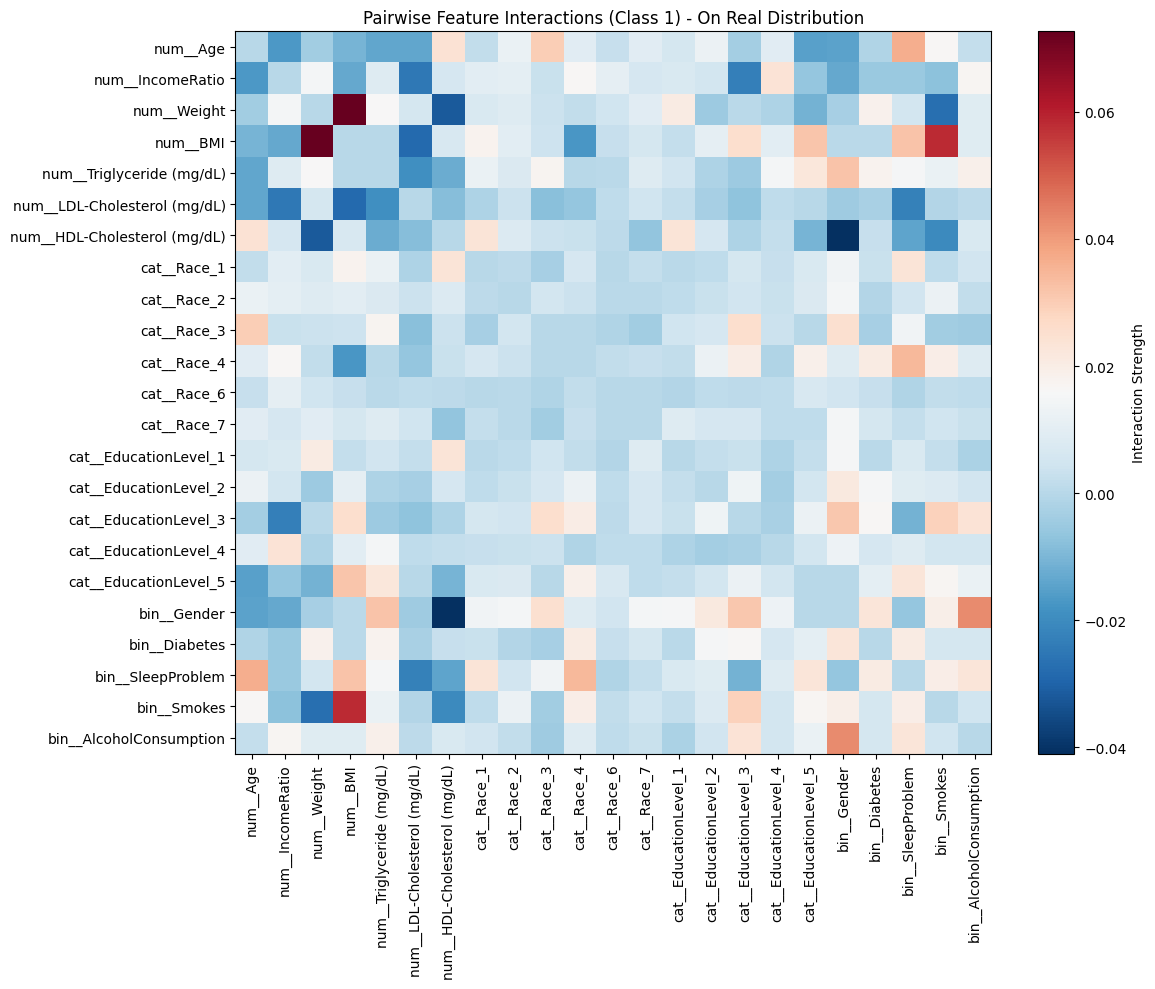

Top 20 Interactions for class 1:
num__Weight × num__BMI: 0.0727
num__BMI × bin__Smokes: 0.0582
bin__Gender × bin__AlcoholConsumption: 0.0426
num__HDL-Cholesterol (mg/dL) × bin__Gender: -0.0410
num__Age × bin__SleepProblem: 0.0365
cat__Race_4 × bin__SleepProblem: 0.0341
num__BMI × bin__SleepProblem: 0.0321
num__Weight × num__HDL-Cholesterol (mg/dL): -0.0320
num__Triglyceride (mg/dL) × bin__Gender: 0.0319
num__BMI × cat__EducationLevel_5: 0.0317
cat__EducationLevel_3 × bin__Gender: 0.0312
num__Age × cat__Race_3: 0.0296
cat__EducationLevel_3 × bin__Smokes: 0.0291
num__BMI × num__LDL-Cholesterol (mg/dL): -0.0283
num__Weight × bin__Smokes: -0.0271
num__BMI × cat__EducationLevel_3: 0.0253
cat__Race_3 × cat__EducationLevel_3: 0.0253
cat__Race_3 × bin__Gender: 0.0248
num__IncomeRatio × num__LDL-Cholesterol (mg/dL): -0.0247
num__Age × num__HDL-Cholesterol (mg/dL): 0.0243


In [ ]:
# Rest of your code (unchanged)
# Use validation data for interaction analysis (real distribution, not SMOTE-synthetic)
print("Using validation data for interaction analysis (real distribution, not SMOTE-synthetic)")

# Get validation samples for analysis (limit to 200 for computational efficiency)
X_val_sample = X_t[val_idx]  # Use validation samples

# For each class
for ci, cname in enumerate(class_names):
    if ci >= len(shap_values_per_class):
        print(f"Skipping interaction analysis for class {cname} - not enough SHAP value arrays")
        continue

    print(f"Computing interactions for class: {cname}")

    # Compute interaction matrix using validation data
    interaction_matrix = compute_shap_interactions_paper_method(
        model, X_val_sample, feature_names, class_idx=ci
    )

    # Visualize interaction matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(interaction_matrix, cmap='RdBu_r', aspect='auto')
    plt.colorbar(label='Interaction Strength')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title(f"Pairwise Feature Interactions (Class {cname}) - On Real Distribution")
    plt.tight_layout()
    plt.show()

    # Show top interactions
    n_features = len(feature_names)
    interactions = [(i, j, interaction_matrix[i, j])
                    for i in range(n_features)
                    for j in range(i+1, n_features)]

    # Sort by absolute interaction strength
    interactions.sort(key=lambda x: abs(x[2]), reverse=True)

    # Display top 10 interactions
    print(f"Top 20 Interactions for class {cname}:")
    for i, j, strength in interactions[:20]:
        print(f"{feature_names[i]} × {feature_names[j]}: {strength:.4f}")
